# Neural & Behavioral Modeling - Week 13 (Exercises)
by 張天瑋

In [94]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import random

In [95]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
Device  0 : Tesla T4
Current: Device  0


## 1 Visualizing the latent space of an autoencoder (4 points)

Please train an autoencoder to project MNIST (training) images to a 2D latent space and visualize how these images are organzed in the latent space, as demonstrated in P.20 of model_13_slides.pdf.

<img src="http://fastforwardlabs.github.io/blog-images/miriam/tableau.1493x693.png" width=80%>


### 1.0 The MNIST Data

In [96]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7f178d56d640>)

In [97]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

<ipython-input-97-117ffd2d9de7>:4: DeprecationWarning: invalid escape sequence '\>'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
<ipython-input-97-117ffd2d9de7>:4: DeprecationWarning: invalid escape sequence '\?'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


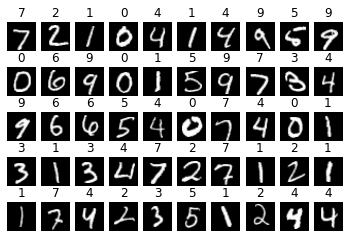

In [98]:
# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

### 1.1 An autoencoder

In [99]:
import torch.nn as nn

# Define the network:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2) # 2-dimensional latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [100]:
model=autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)


### 1.2 Your training (2 points)

In [101]:
CONFIG = {
  "seed" : 7777,
  "batchSize": 128,

  "n_epochs": 50,
  "lr": 1e-3,
  "savePath": "./saved_model.pth",
}

In [102]:
class colors:
  GREEN = '\033[92m' #GREEN
  RED = '\033[91m' #RED
  RESET = '\033[0m' #RESET COLOR

In [103]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [104]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

In [105]:
class MinstDataset(Dataset):
    def __init__(self, x, y, is_train=True):
        self.x = x
        if is_train:
            self.y = y
        self.is_train = is_train
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.is_train:
            return torch.tensor(self.x[idx]).float(), torch.tensor(self.y[idx]).float()
        else:
            return torch.tensor(self.x[idx]).float()

In [106]:
# x_train, y_train, x_test, y_test
training_set = MinstDataset(x_train, y_train)
val_set = MinstDataset(x_test, y_test)
trainloader = DataLoader(training_set, batch_size=CONFIG["batchSize"], shuffle=True)
validloader = DataLoader(val_set, batch_size=CONFIG["batchSize"], shuffle=False)

In [107]:
def train(trainloader, model, loss_fn, optimizer, device):
    size = len(trainloader.dataset)

    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        encode, decode = model(X)
        loss = loss_fn(decode, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()

        # if batch % 10 == 0:
        #     current = batch * len(X)
        #     print(f"Progress: [{current:>5d}/{size:>5d}]")

    train_loss = (total_loss/len(trainloader))
    # val_loss = validate(validloader, model, loss_fn, device)

    print(f"Training loss: {train_loss:>7f}")

    return train_loss

In [108]:
def validate(validloader, model, loss_fn, device):
    model.eval()
    results = []                                
    for X, y in validloader:
        X, y = X.to(device), y.to(device)       
        with torch.no_grad():
            encode, decode = model(X)
            # print(encode.shape)
            # print(y.unsqueeze(1).shape)
            result = torch.cat((encode, y.unsqueeze(1)), 1)
            results.append(result.detach().cpu()) 
    results = torch.cat(results, dim=0).numpy()

    return results

In [109]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
setup_seed(CONFIG['seed'])
model = autoencoder().to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=0)

Using cuda device


In [110]:
train_loss_hist = []
for epoch in range(CONFIG['n_epochs']):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer, device)
    train_loss_hist.append(train_loss)
torch.save(model.state_dict(), CONFIG['savePath'])
print("Done!")

Epoch 1
-------------------------------
Training loss: 0.058786
Epoch 2
-------------------------------
Training loss: 0.049965
Epoch 3
-------------------------------
Training loss: 0.046989
Epoch 4
-------------------------------
Training loss: 0.044879
Epoch 5
-------------------------------
Training loss: 0.043306
Epoch 6
-------------------------------
Training loss: 0.042320
Epoch 7
-------------------------------
Training loss: 0.041615
Epoch 8
-------------------------------
Training loss: 0.041070
Epoch 9
-------------------------------
Training loss: 0.040522
Epoch 10
-------------------------------
Training loss: 0.040113
Epoch 11
-------------------------------
Training loss: 0.039776
Epoch 12
-------------------------------
Training loss: 0.039501
Epoch 13
-------------------------------
Training loss: 0.039203
Epoch 14
-------------------------------
Training loss: 0.038978
Epoch 15
-------------------------------
Training loss: 0.038741
Epoch 16
-------------------------

In [123]:
model = autoencoder().to(device)
model.load_state_dict(torch.load(CONFIG['savePath']))
results = validate(validloader, model, loss_fn, device)
print(results.shape)
results = [[row[0] , row[1], int(row[2])] for row in results]
print(results[0])

(10000, 3)
[0.29206237, 0.22397466, 7]


### 1.3 Your visualization (2 points)

In [124]:
import pandas as pd
df = pd.DataFrame(results, columns = ['x','y','label'])
print(df.head())

          x         y  label
0  0.292062  0.223975      7
1  3.616918  1.539695      2
2  2.155420 -1.039250      1
3 -2.937021  4.281658      0
4 -1.044731  0.197925      4


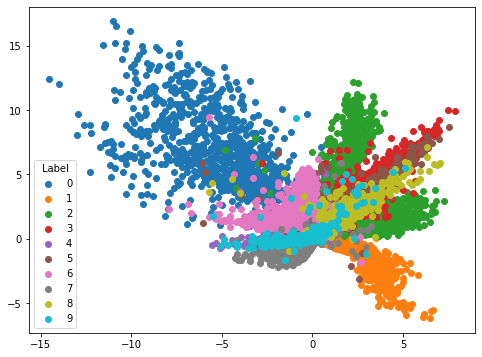

In [125]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

for n, grp in df.groupby('label'):
    ax.scatter(x = "x", y = "y", data=grp, label=n)
ax.legend(title="Label")

plt.show()

## 2 Integer Factorization (4 points)

Here we explore the possibilty that a neural network may be able to judge whether an input integer is a prime number or not.

* Computational problem: tell if an input is a prime number 

* Network Input: an integer in binary code (e.g., 0→000000000000000 (15 bits); 1→000000000000001; 2→000000000000010)

* Network Output: 1 unit (1=yes; 0=no)

* Network Architecture: your choice

* Data set: You can enlarge your training and testing data sets, if necessary. Training accuracies and testing accuraces are both informative but of course we care more about the testing ones.

### 2.1 The data set

In [221]:
from math import sqrt; from itertools import count, islice

def isPrime(n):
    return n > 1 and all(n%i for i in islice(count(2), int(sqrt(n)-1)))

ifPrime=np.vectorize(isPrime)    

x=np.arange(32768) #2^15
y=ifPrime(x).astype(int) 

# Training-testing splits:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Training data:
print(x_train.shape,x_train)
print(y_train.shape,y_train)

# Testing data:
print(x_test.shape,x_train)
print(y_test.shape,y_train)

# Conversion of an integer to its binary code:
format(x_train[0], '015b') # 15-dimensional feature vector
x_train = np.array([[int(x) for x in list(format(i, '015b'))] for i in x_train])
x_test = np.array([[int(x) for x in list(format(i, '015b'))] for i in x_test])
print(x_train.shape)
print(x_test.shape)

(26214,) [30490 18527  3698 ... 10153  6160 19654]
(26214,) [0 0 0 ... 0 0 0]
(6554,) [30490 18527  3698 ... 10153  6160 19654]
(6554,) [0 0 0 ... 0 0 0]
(26214, 15)
(6554, 15)


### 2.2 Your computational experiments (2 points)

In [232]:
CONFIG = {
  "seed" : 7777,
  "batchSize": 128,

  "n_epochs": 50,
  "lr": 1e-3,
}
class colors:
  GREEN = '\033[92m' #GREEN
  RED = '\033[91m' #RED
  RESET = '\033[0m' #RESET COLOR

In [233]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [234]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

In [235]:
class PrimeDataset(Dataset):
    def __init__(self, x, y, is_train=True):
        self.x = x
        if is_train:
            self.y = y
        self.is_train = is_train
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.is_train:
            return torch.tensor(self.x[idx]).float(), torch.tensor(self.y[idx]).float()
        else:
            return torch.tensor(self.x[idx]).float()

In [236]:
# x_train, y_train, x_test, y_test
training_set = PrimeDataset(x_train, y_train)
test_set = PrimeDataset(x_test, y_test)
trainloader = DataLoader(training_set, batch_size=CONFIG["batchSize"], shuffle=True)
testloader = DataLoader(test_set, batch_size=CONFIG["batchSize"], shuffle=False)

In [237]:
class MyModel(nn.Module):
    def __init__(self,input_dim):
        super(MyModel, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 2)
        )
    def forward(self, x):
        x = self.layer(x)
        return x

In [238]:
def train(trainloader, validloader, model, loss_fn, optimizer, device):
    size = len(trainloader.dataset)

    total_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(trainloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()

        # if batch % 10 == 0:
        #     current = batch * len(X)
        #     print(f"Progress: [{current:>5d}/{size:>5d}]")
        train_acc += get_acc(pred, y)
    train_loss = (total_loss/len(trainloader))
    train_acc = train_acc / len(trainloader)
    val_loss, valid_acc = validate(validloader, model, loss_fn, device)

    print(f"Train loss: {train_loss:>7f} Train Acc: {train_acc:>7f} Valid loss: {val_loss:>7f} Valid Acc: {valid_acc:>7f}")

    return train_loss, val_loss

In [239]:
def validate(validloader, model, loss_fn, device):
    model.eval()                                
    total_loss = 0
    valid_acc = 0
    for X, y in validloader:
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)       
        with torch.no_grad():
            pred = model(X)
            loss = loss_fn(pred, y)
        total_loss += loss.detach().cpu().item()
        valid_acc += get_acc(pred, y)
    total_loss = total_loss / len(validloader)
    valid_acc = valid_acc / len(validloader)
    return total_loss , valid_acc

In [240]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
setup_seed(CONFIG['seed'])
model = MyModel(15).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=0)

Using cuda device


In [241]:
train_loss_hist = []
val_loss_hist = []
for epoch in range(CONFIG['n_epochs']):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, val_loss = train(trainloader, testloader, model, loss_fn, optimizer, device)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    # if val_loss < min_val_mse:
    #     es_cnt = 0
    #     print(colors.GREEN, f'Validation Loss Decreased({min_val_mse:.6f}--->{val_loss:.6f}) Saving The Model', colors.RESET)
    #     min_val_mse = val_loss

    #     # Saving State Dict
    #     torch.save(model.state_dict(), CONFIG['savePath'])
    # elif es_cnt < CONFIG['earlyStop']:
    #     es_cnt += 1
    # else:
    #     print(colors.RED + '\nModel is not imporving, so we halt the training session.', colors.RESET)
    #     break
    print('')
print("Done!")

Epoch 1
-------------------------------
Training loss: 0.407924 Training Acc: 0.857342 Validation loss: 0.306117 Validation Acc: 0.887528

Epoch 2
-------------------------------
Training loss: 0.290979 Training Acc: 0.892033 Validation loss: 0.278386 Validation Acc: 0.887528

Epoch 3
-------------------------------
Training loss: 0.273814 Training Acc: 0.893740 Validation loss: 0.273341 Validation Acc: 0.887528

Epoch 4
-------------------------------
Training loss: 0.268908 Training Acc: 0.893775 Validation loss: 0.271777 Validation Acc: 0.887528

Epoch 5
-------------------------------
Training loss: 0.264239 Training Acc: 0.893834 Validation loss: 0.270897 Validation Acc: 0.887528

Epoch 6
-------------------------------
Training loss: 0.263298 Training Acc: 0.893863 Validation loss: 0.270526 Validation Acc: 0.887528

Epoch 7
-------------------------------
Training loss: 0.262021 Training Acc: 0.893814 Validation loss: 0.270297 Validation Acc: 0.887528

Epoch 8
-------------------

### 2.3 Your discussion (2 points)

任何連續函數，神經網絡都能擬合出來。
但質數的分佈並不是連續的，也沒有周期性。
因為模型只能用外插或內插來預測，所以雖然可以將已知樣本良好地擬合，但對未知樣本的預測效果非常差。

In [243]:
%%shell
jupyter nbconvert --to html ./model_13_exercises.ipynb

[NbConvertApp] Converting notebook ./model_13_exercises.ipynb to html
[NbConvertApp] Writing 472038 bytes to ./model_13_exercises.html
